In [1]:
import sys
from source_data import Requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# output folders
SHORT120 = r'output_logs/211027170646'
SHORT180 = r'output_logs/211027145449'
SHORT240 = r'output_logs/211027070856'
folders = [SHORT120,SHORT180,SHORT240]

In [2]:
# get the model output logs
out_logs = []
for MW,folder in zip([120,180,240],folders): 
    
    hours = []
    for fnm in os.listdir(folder):

        
        if fnm[0] != 'c':
            hours.append(pd.read_csv(os.path.join(folder,fnm),dtype=dict(passenger_id=int)))
            

    # concatenate them together
    mw_df = pd.concat(hours).sort_values(['time_stamp']).reset_index(drop=True)
    mw_df['MaxWait'] = MW

    out_logs.append(mw_df)
    
out_df = pd.concat(out_logs,ignore_index=True)

# get the min and max times
MINT = out_df['time_stamp'].min()
MAXT = out_df['time_stamp'].max()

Check the passengers are only picked up and dropped off once:

In [3]:
np.unique((out_df['passenger_id'].astype(str)+out_df['event']+out_df['MaxWait'].astype(str)).value_counts().values)

array([1])

In [4]:
# get the requests in the first hour
reqs = Requests().read_requests()
reqs = reqs[(reqs['time']>=MINT)&(reqs['time']<=MAXT)]

# how many hours is this?
print(f"{(MAXT-MINT)/3600:0.1f}")

# how many if we ignore the first hour
focus = reqs[reqs['time']>MINT+3600]
print(focus.shape[0], "request")

MINW = reqs['window'].min() 
MAXW = reqs['window'].max()

reqs.head()

2.0
25857 request


,time,from_node,to_node,window,day,hour,latest_pickup
2141323,500430,968,642,16681,5,19,500550
2141324,500430,993,584,16681,5,19,500550
2141325,500430,854,1699,16681,5,19,500550
2141326,500430,33,221,16681,5,19,500550
2141327,500431,2444,1166,16681,5,19,500551


Peak requests 239.3


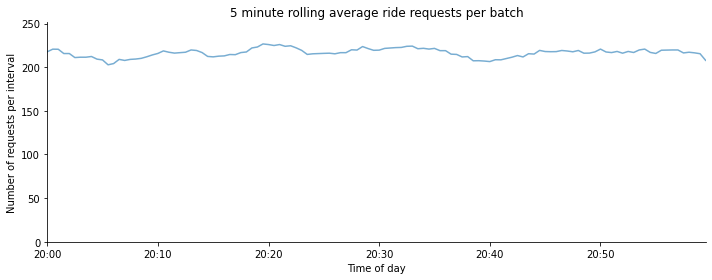

In [5]:
# summarise the requests by hour
numreqs_by_window = reqs.groupby(['window']).\
    agg('count')['time'].\
    rename("num_requests")

# plot a rolling 15 minute average
fig,ax = plt.subplots(figsize=[10,4])

smoothing = 10
numreqs_by_window.\
    rolling(smoothing).mean().plot(alpha=0.6,ax=ax)

print("Peak requests",numreqs_by_window.\
    rolling(smoothing).mean().max())

# create some xticks and labels
make_label = lambda x: f"{x//(120)%24}:{x//(2)%60:02.0f}"
window_ticks = np.arange(MINW,MAXW,20)
wt_labels = [make_label(tick) for tick in window_ticks]
ax.set_xticks(window_ticks)
ax.set_xticklabels(wt_labels)

# count the number of request picked up in each window
ax.set_title("5 minute rolling average ride requests per batch")
ax.set_ylabel("Number of requests per interval")
ax.set_xlabel("Time of day")
ax.set_xlim([MINW+120,MAXW])
ax.set_ylim([0,numreqs_by_window.rolling(smoothing).mean().max()*1.05])
sns.despine()
fig.tight_layout()
plt.savefig(r"results/numrequests_short.jpg")

Demand peaks between 7 and 8pm @ 240 requests, we show a rolling average as the numbers seem to oscillate between a low/high 

In [6]:
# get the time windows for the pickups
pickups = out_df[out_df['event']=='pickup'].reset_index(drop=True)
pickups = pickups.join(reqs.loc[:,'window'],on=['passenger_id'])
numpicks_by_window = pickups.groupby(['window']).agg('count')['time_stamp'].rename("num_pickups")

# stick it all together
result = pd.concat([numreqs_by_window,numpicks_by_window],axis=1)

Min 0.94 Max 0.99 Average 0.96
Min 0.98 Max 1.0 Average 0.99
Min 0.99 Max 1.0 Average 1.0


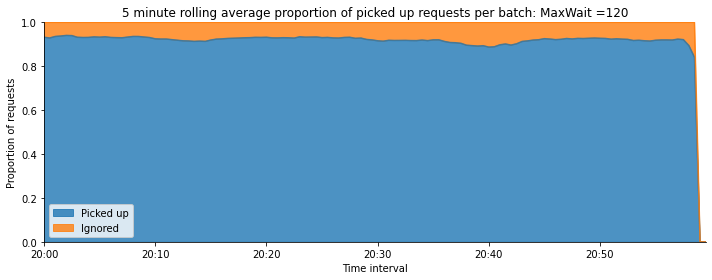

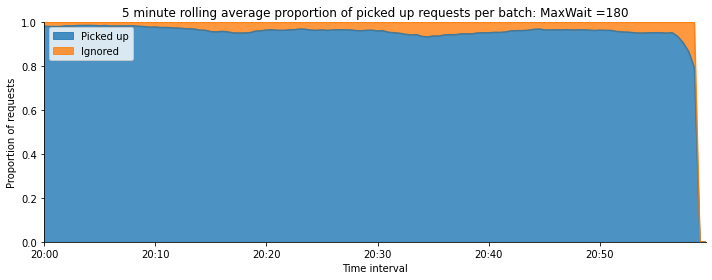

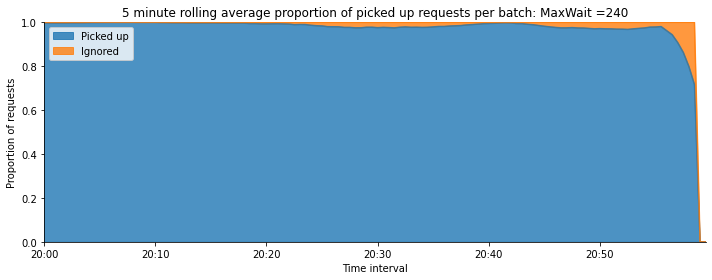

In [15]:
for MW,df in out_df.groupby("MaxWait"):
    # get the time windows for the pickups
    pickups = df[df['event']=='pickup'].reset_index(drop=True)
    pickups = pickups.join(reqs.loc[:,'window'],on=['passenger_id'])
    numpicks_by_window = pickups.groupby(['window']).agg('count')['time_stamp'].rename("num_pickups")

    # stick it all together
    result = pd.concat([numreqs_by_window,numpicks_by_window],axis=1)
    
    
    # need to convert to proportion
    proportion = result.copy()
    proportion['Picked up'] = proportion['num_pickups'] / proportion['num_requests']
    proportion['Ignored'] = 1 - proportion['Picked up']

    # plot proportion of requests that are picked up
    fig,ax = plt.subplots(figsize=[10,4])
    ax = proportion.loc[:,['Picked up','Ignored']].rolling(smoothing).mean().plot.area(ax=ax,alpha=0.8)

    # print min and max utilisations
    chop = int(len(proportion)*0.1)
    print("Min",round(proportion.loc[:,'Picked up'].\
                      rolling(smoothing).mean().iloc[:chop].min(),2),
         "Max",round(proportion.loc[:,'Picked up'].\
                     rolling(smoothing).mean().iloc[:chop].max(),2),
         "Average",round(proportion.loc[:,'Picked up'].\
                         rolling(smoothing).mean().iloc[:chop].mean(),2))

    # format the plot
    ax.set_xticks(window_ticks)
    ax.set_xticklabels(wt_labels)
    ax.set_xlabel("Time interval")
    ax.set_ylabel("Proportion of requests")
    ax.set_title(f"5 minute rolling average proportion of picked up requests per batch: MaxWait ={MW}")
    ax.set_xlim([MINW+120,MAXW])
    ax.set_ylim([0,1])
    sns.despine()
    fig.tight_layout()
    plt.savefig(f"results/rolling_pickedup_{MW}.jpg")

In [8]:
def cab_utilisation(cab_data):
        
    # convert pickup / dropoffs to change in state
    state = cab_data.copy().sort_values(['time_stamp'])
    state['change'] = cab_data['event'].copy().map(lambda x: 1 if x == 'pickup' else -1)
    
    # where concurrent events occur, we have sum them to get the net result
    change = state.groupby(['time_stamp'])['change'].agg('sum')
        
    # apply cumsum to get payload load
    payload = np.cumsum(change)
    
    # check if utilised and convert to number  
    utilised = pd.DataFrame((payload > 0).astype(int),index=payload.index).reset_index()
    
    return utilised

def fill_gaps(cab_data):
    
    # add the common index
    cab_data = cab_data.join(dummy_col,on=['time_stamp'],how='right').\
        loc[:,['time_stamp','utilised']].\
        sort_values(['time_stamp']).reset_index(drop=True)
        
    # if the utilisation at time 0 is na then set it to 0
    if cab_data['utilised'].isnull().iloc[0]:
        cab_data.iloc[0,1] = 0
        
    # now fill down to the next state change
    return cab_data.fillna(method='ffill').set_index(['time_stamp'])

7139
Min 0.83 Max 0.93 Mean 0.89
7137
Min 0.85 Max 0.95 Mean 0.9
7138
Min 0.86 Max 0.95 Mean 0.91


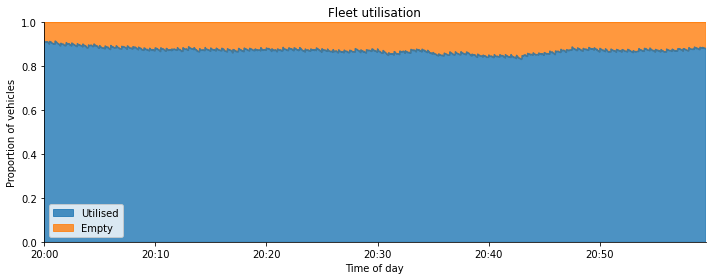

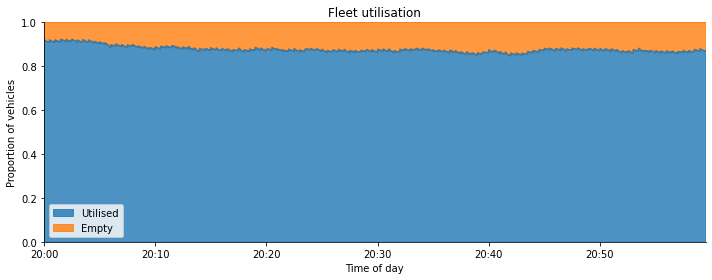

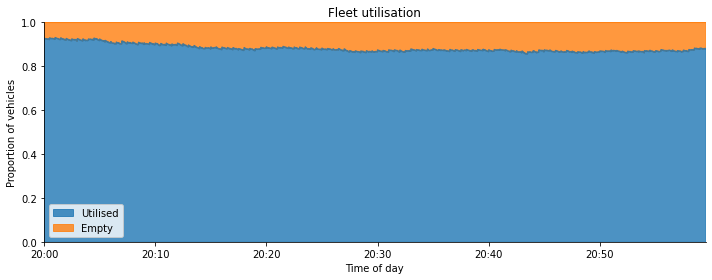

In [14]:
# create some ticks for all time
bounds = [MINT+3600,MAXT]
make_label_secs = lambda x: f"{x//(3600)%24}:{x//(60)%60:02.0f}"
sec_ticks = np.arange(bounds[0],bounds[1],600)
st_labels = [make_label_secs(tick) for tick in sec_ticks]
ax.set_xticks(sec_ticks)
ax.set_xticklabels(st_labels)

for MW,df in out_df.groupby(["MaxWait"]):
    
    # assess whether a cab is utilised or not > 0 passengers
    cab_use = []
    for cab,data in df.groupby(['cab_id']):

        cab_util = cab_utilisation(data)
        cab_util['cab_id'] = cab
        cab_use.append(cab_util)

    cab_use = pd.concat(cab_use,ignore_index=True).rename(columns=dict(change='utilised'))


    # create a common time index for all cabs
    # its a little bit shorter than all time
    time_index = pd.Index(cab_use['time_stamp'].unique(),name="time_index").sort_values()
    dummy_col = pd.Series(data=[np.nan]*time_index.shape[0],index=time_index,name='dummy')

    utilisations = []
    for cab,data in cab_use.groupby(['cab_id']):
        utilisations.append(fill_gaps(data))
        
        
    # create a container to add up utilised cabs in each time slot
    num_utilised = np.zeros((dummy_col.shape[0],))
    for cab_util in utilisations:
    
        num_utilised += cab_util.values.flatten()
        
    # now caculate the proportion utilised
    proportion_utilised = num_utilised / 3000
    diff_utilised = 1 - proportion_utilised
    to_plot = pd.concat([pd.Series(proportion_utilised,index=time_index),
                         pd.Series(diff_utilised,index=time_index)],axis=1)
    to_plot.columns = ["Utilised","Empty"]
    
    # plot proportion of requests that are picked up
    fig,ax = plt.subplots(figsize=[10,4])
    ax = to_plot.plot.area(ax=ax,alpha=0.8)

    # what are the min,max and mean utilisations
    chop = int(len(proportion_utilised)*0.1)
    print("Min",round(proportion_utilised[chop:-chop].min(),2),
          "Max",round(proportion_utilised[chop:-chop].max(),2),
          "Mean",round(proportion_utilised[chop:-chop].mean(),2))

    # create some ticks for all time
    ax.set_xticks(sec_ticks)
    ax.set_xticklabels(st_labels)

    # format the plot
    ax.set_xlabel("Time of day")
    ax.set_ylabel("Proportion of vehicles")
    ax.set_title("Fleet utilisation")
    ax.set_ylim([0,1])
    ax.set_xlim([MINT+3600,MAXT])
    sns.despine()
    fig.tight_layout()
    plt.savefig(f"results/utilised_cabs_{MW}.jpg")